<a href="https://colab.research.google.com/github/Moh-Sarem/Tutorials/blob/main/Feature_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Permutation Importance
This notebook explains how to determine feature importance through permutation and how the results can sometimes differ from the feature importances given by tree-based algorithms such as random forest.

The data used here is the credit card default data, taken from UCI ML repository hosted in Kaggle, available here: https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset

## 1. Setting up the environment
Importing all the required packages.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
import progressbar
from google.colab import files

## 2. Kaggle setup
The two cells below make use of the Kaggle API to download the data and unzip to be used for our analysis. Please make sure you have your 'kaggle.json' file available to be uploaded upon execution of the cell below.

In [2]:
!pip install kaggle --upgrade -q
!mkdir ~/.kaggle

files.upload()

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohsarm","key":"441f065676e33a522e62d6be8c628e03"}'}

In [3]:
!mv kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download -d uciml/default-of-credit-card-clients-dataset
!unzip default-of-credit-card-clients-dataset.zip

credit=pd.read_csv('UCI_Credit_Card.csv').drop(columns=['ID'])

  0% 0.00/0.98M [00:00<?, ?B/s]
100% 0.98M/0.98M [00:00<00:00, 157MB/s]
Archive:  default-of-credit-card-clients-dataset.zip
  inflating: UCI_Credit_Card.csv     


In [4]:
credit.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [12]:
# Explore attributes before mapping them
cats=['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'] #categorical columns
for c in cats:
    print("Column {} has {} attribute: {}".format(c, credit[c].nunique(), credit[c].unique()))

Column SEX has 2 attribute: [2, 1]
Categories (2, int64): [1, 2]
Column EDUCATION has 7 attribute: [2, 1, 3, 5, 4, 6, 0]
Categories (7, int64): [0, 1, 2, 3, 4, 5, 6]
Column MARRIAGE has 4 attribute: [1, 2, 3, 0]
Categories (4, int64): [0, 1, 2, 3]
Column PAY_0 has 11 attribute: [2, -1, 0, -2, 1, ..., 4, 8, 7, 5, 6]
Length: 11
Categories (11, int64): [-2, -1, 0, 1, ..., 5, 6, 7, 8]
Column PAY_2 has 11 attribute: [2, 0, -1, -2, 3, ..., 7, 4, 1, 6, 8]
Length: 11
Categories (11, int64): [-2, -1, 0, 1, ..., 5, 6, 7, 8]
Column PAY_3 has 11 attribute: [-1, 0, 2, -2, 3, ..., 6, 7, 1, 5, 8]
Length: 11
Categories (11, int64): [-2, -1, 0, 1, ..., 5, 6, 7, 8]
Column PAY_4 has 11 attribute: [-1, 0, -2, 2, 3, ..., 5, 7, 6, 1, 8]
Length: 11
Categories (11, int64): [-2, -1, 0, 1, ..., 5, 6, 7, 8]
Column PAY_5 has 10 attribute: [-2, 0, -1, 2, 3, 5, 4, 7, 8, 6]
Categories (10, int64): [-2, -1, 0, 2, ..., 5, 6, 7, 8]
Column PAY_6 has 10 attribute: [-2, 2, 0, -1, 3, 6, 4, 7, 8, 5]
Categories (10, int64): 

## 3. Fitting a Random Forest classifier
Let us one-hot encode the categorical variables, split the dataset and fit a random forest classifier.

In [48]:
cats=['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'] #categorical columns
for c in cats:
    credit[c]=credit[c].astype('category')

credit_ohe=pd.get_dummies(credit, drop_first=True) #One-hot encoding the categorical variables

##Exploring distribution of class label


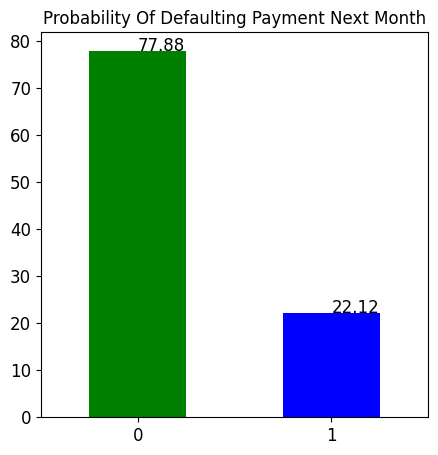

In [49]:
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt # plotting

data =(credit_ohe['default.payment.next.month'].
          value_counts(normalize= True)*100)
data.plot.bar(figsize=(5,5),color =['green','blue'])
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)
plt.title("Probability Of Defaulting Payment Next Month", fontsize=12)
for x,y in zip([0,1],data):
  plt.text(x,round(y,2),round(y,2),fontsize=12)
plt.show()

## Choice splitting method

In [50]:
y=credit_ohe['default.payment.next.month']
X=credit_ohe.drop(columns=['default.payment.next.month'])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

## Train Random Forest Classifier

In [51]:
rf=RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier()

Let us see how our model performs against the training and test data sets.

In [52]:
print('Training set metrics:')
print('Accuracy:', accuracy_score(y_train, rf.predict(X_train)))
print('Precision:', precision_score(y_train, rf.predict(X_train)))
print('Recall:', recall_score(y_train, rf.predict(X_train)))
print('F1:', f1_score(y_train, rf.predict(X_train)))
print('---------------')
print('Test set metrics:')
print('Accuracy:', accuracy_score(y_test, rf.predict(X_test)))
print('Precision:', precision_score(y_test, rf.predict(X_test)))
print('Recall:', recall_score(y_test, rf.predict(X_test)))
print('F1:', f1_score(y_test, rf.predict(X_test)))

Training set metrics:
Accuracy: 0.9995111111111111
Precision: 0.9981942215088283
Recall: 0.9995981514968857
F1: 0.9988956932034937
---------------
Test set metrics:
Accuracy: 0.8173333333333334
Precision: 0.6600221483942414
Recall: 0.35925256178420734
F1: 0.4652615144418423


The model seems to be overfitting, with the test set metrics varying significantly from those of the training set.

## 4. Random Forest feature importances
Let us see which features were deemed important by the model by plotting the feature importances.

In [53]:
col_sorted_by_importance=rf.feature_importances_.argsort()
feat_imp=pd.DataFrame({
    'cols':X.columns[col_sorted_by_importance],
    'imps':rf.feature_importances_[col_sorted_by_importance]
})

In [54]:
!pip install plotly_express --upgrade -q

In [59]:
import plotly_express as px
import plotly.offline as po
px.bar(feat_imp.sort_values(['imps'], ascending=False)[:25], x='cols', y='imps', labels={'cols':'column', 'imps':'feature importance'})

Surprisingly, 'AGE' is the most important feature for credit card default. Let us now validate the same by finding the feature importances through permutation.

## 5. Permutation importance
Permutation importance is a technique where we shuffle the values of a single column and run the model to see how the scores get affected. If the scores are affected greatly, then the feature is highly important to the model and if not, it does not add significant value to the model.

Let us see the feature importances for recall score on the test dataset.

In [60]:
def PermImportance(X, y, clf, metric, num_iterations=100):
    '''
    Calculates the permutation importance of features in a dataset.
    Inputs:
    X: dataframe with all the features
    y: array-like sequence of labels
    clf: sklearn classifier, already trained on training data
    metric: sklearn metric, such as accuracy_score, precision_score or recall_score
    num_iterations: no. of repetitive runs of the permutation
    Outputs:
    baseline: the baseline metric without any of the columns permutated
    scores: differences in baseline metric caused by permutation of each feature, dict in the format {feature:[diffs]}
    '''
    bar=progressbar.ProgressBar(max_value=len(X.columns))
    baseline_metric=metric(y, clf.predict(X))
    scores={c:[] for c in X.columns}
    for c in X.columns:
        X1=X.copy(deep=True)
        for _ in range(num_iterations):
            temp=X1[c].tolist()
            random.shuffle(temp)
            X1[c]=temp
            score=metric(y, clf.predict(X1))
            scores[c].append(baseline_metric-score)
        bar.update(X.columns.tolist().index(c))
    return baseline_metric, scores

In [56]:
baseline, scores=PermImportance(X_test, y_test, rf, recall_score, num_iterations=10)

 98% (81 of 82) |####################### | Elapsed Time: 0:03:23 ETA:   0:00:02

Let us now plot the top percent changes in recall that resulted from permuting each feature.

In [61]:
percent_changes={c:[] for c in X.columns}
for c in scores:
    for i in range(len(scores[c])):
        percent_changes[c].append(scores[c][i]/baseline*100)

In [62]:
px.bar(
    pd.DataFrame.from_dict(percent_changes).melt().groupby(['variable']).mean().reset_index().sort_values(['value'], ascending=False)[:25], 
    x='variable', 
    y='value', 
    labels={
        'variable':'column', 
        'value':'% change in recall'
        }
       )

We can see that 'AGE' is not one of the top most important features when we use the permutation technique to determine feature importances.

# Test other Feature Selection Techniques
* Using Pearson Correlation

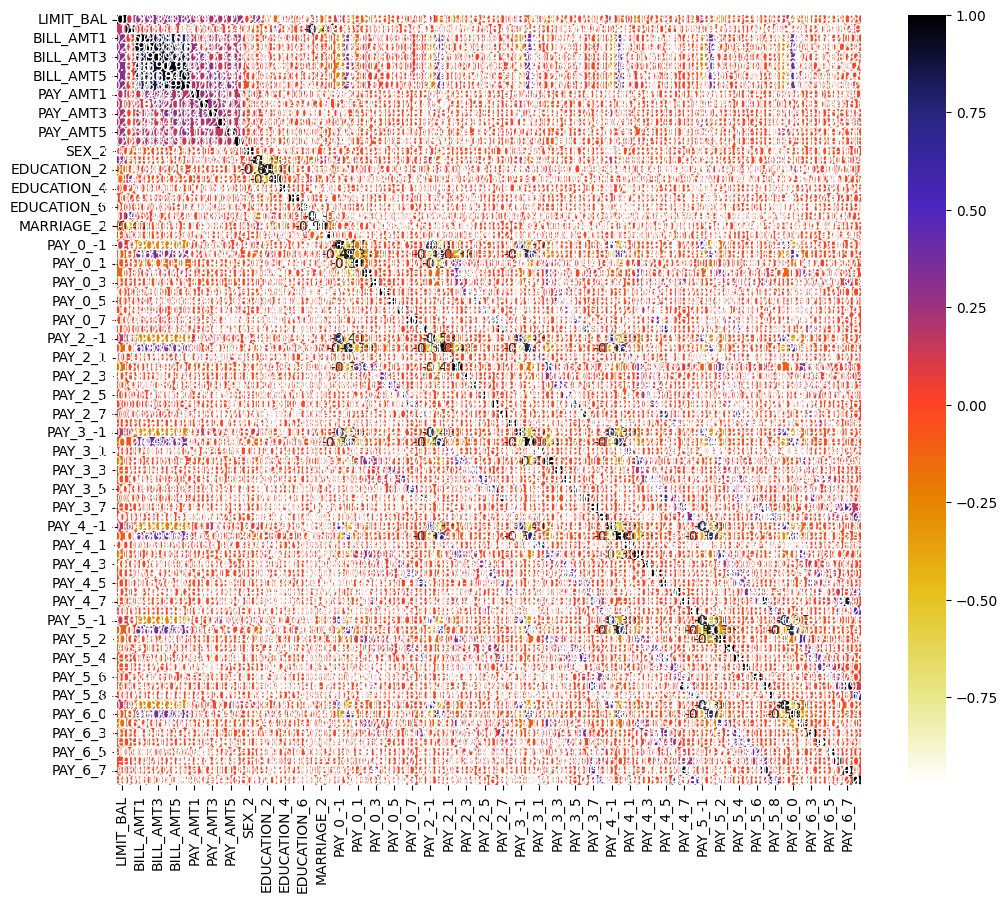

In [63]:
import seaborn as sns
cor = X_train.corr()
plt.figure(figsize=(12,10))
sns.heatmap(cor, cmap=plt.cm.CMRmap_r,annot=True)
plt.show()  

NOTE: If the value is near to 1 that means those two features are correlated and we can drop any one of them.
###Finding the correlated features

In [ ]:
def correlation(dataset, threshold):
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
              colname = corr_matrix.columns[i]
              col_corr.add(colname)
    return col_corr     

corr_features = correlation(X_train, 0.7)
corr_features

In [ ]:
#Removing correlated features
X_train.drop(corr_features,axis=1)
X_test.drop(corr_features,axis=1)


In [94]:
def sklearn_Clr():
  rf=RandomForestClassifier(n_estimators=100)
  rf.fit(X_train, y_train)
  trn_metric=[]
  tes_metric=[]
  # print('Training set metrics:')
  trn_metric.append({'Accuracy': accuracy_score(y_train, rf.predict(X_train)),
                    'Precision': precision_score(y_train, rf.predict(X_train)),
                    'Recall': recall_score(y_train, rf.predict(X_train)),
                    'F1': f1_score(y_train, rf.predict(X_train))})
  df1= pd.DataFrame(trn_metric)
  # print('---------------')
  # print('Test set metrics:')
  tes_metric.append({'Accuracy': accuracy_score(y_test, rf.predict(X_test)),
                         'Precision': precision_score(y_test, rf.predict(X_test)),
                         'Recall': recall_score(y_test, rf.predict(X_test)),
                         'F1': f1_score(y_test, rf.predict(X_test))})
  df2=pd.DataFrame(tes_metric)

  return rf,df1,df2

In [113]:
def plot():
  clr, train_metric, test_metric=sklearn_Clr()
  df=pd.concat([train_metric,test_metric], keys=['Training', 'Testing'], ignore_index= False)

  col_sorted_by_importance=clr.feature_importances_.argsort()
  feat_imp=pd.DataFrame({
    'cols':X.columns[col_sorted_by_importance],
    'imps':clr.feature_importances_[col_sorted_by_importance]
  })

  px.bar(feat_imp.sort_values(['imps'], ascending=False)[:25], x='cols', y='imps', labels={'cols':'column', 'imps':'feature importance'})
  return df

In [115]:
df = plot()
df

,,Accuracy,Precision,Recall,F1
Training,0,0.999467,0.998995,0.998594,0.998794
Testing,0,0.819200,0.670416,0.359253,0.467818


### Chi-square

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np

#Calculating Fscore and p value
f_p_values=chi2(np.abs(X_train), np.abs(y_train))
f_p_values

Chi-square is used to find F-score and p-values for all features. So in this case the first array is for F score and the second array is for p- values. Now, what is the importance of these two values? And the more the value of the F score the more important the feature is and the lesser the value of the p-value the more important will be the feature.
###Representing in list form

In [105]:
#Representing in list form

p_values=pd.Series(f_p_values[1])
p_values.index=X_train.columns
# p_values

#Sorting values in ascending order
p_values.sort_index(ascending=False)


SEX_2        0.000770
PAY_AMT6     0.000000
PAY_AMT5     0.000000
PAY_AMT4     0.000000
PAY_AMT3     0.000000
               ...   
BILL_AMT4    0.000000
BILL_AMT3    0.000000
BILL_AMT2    0.000000
BILL_AMT1    0.000000
AGE          0.008343
Length: 82, dtype: float64

### Mutual information gain


In [116]:
#importing mutual information gain
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

array([1.15918240e-02, 0.00000000e+00, 5.26613397e-03, 6.18523834e-03,
       2.00273387e-03, 3.09944378e-03, 4.69933227e-03, 2.72242460e-03,
       2.38527850e-02, 1.88483389e-02, 1.79966258e-02, 1.75895091e-02,
       1.40629718e-02, 1.75824716e-02, 3.24521216e-03, 0.00000000e+00,
       2.63925903e-03, 0.00000000e+00, 7.10568234e-04, 0.00000000e+00,
       1.46575895e-04, 6.02510478e-03, 0.00000000e+00, 0.00000000e+00,
       1.46426643e-03, 2.97635570e-02, 6.13322144e-03, 5.28413747e-02,
       1.38789250e-02, 0.00000000e+00, 5.70949374e-04, 4.53516400e-03,
       1.90671432e-03, 0.00000000e+00, 2.10247788e-04, 1.29436428e-02,
       0.00000000e+00, 4.04871777e-02, 6.69653585e-03, 0.00000000e+00,
       1.94453715e-03, 1.20428607e-03, 2.50498237e-03, 1.65713221e-03,
       4.17997515e-03, 7.82141107e-03, 0.00000000e+00, 3.20184405e-02,
       0.00000000e+00, 2.16126007e-03, 0.00000000e+00, 2.62375343e-03,
       0.00000000e+00, 2.09930284e-03, 2.29926469e-03, 8.72085915e-03,
      

In [117]:
#Representing in list form
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

PAY_0_2     0.052841
PAY_2_2     0.040487
PAY_3_2     0.032018
PAY_0_0     0.029764
PAY_AMT1    0.023853
              ...   
PAY_2_4     0.000000
AGE         0.000000
PAY_3_1     0.000000
PAY_3_3     0.000000
PAY_5_4     0.000000
Length: 82, dtype: float64

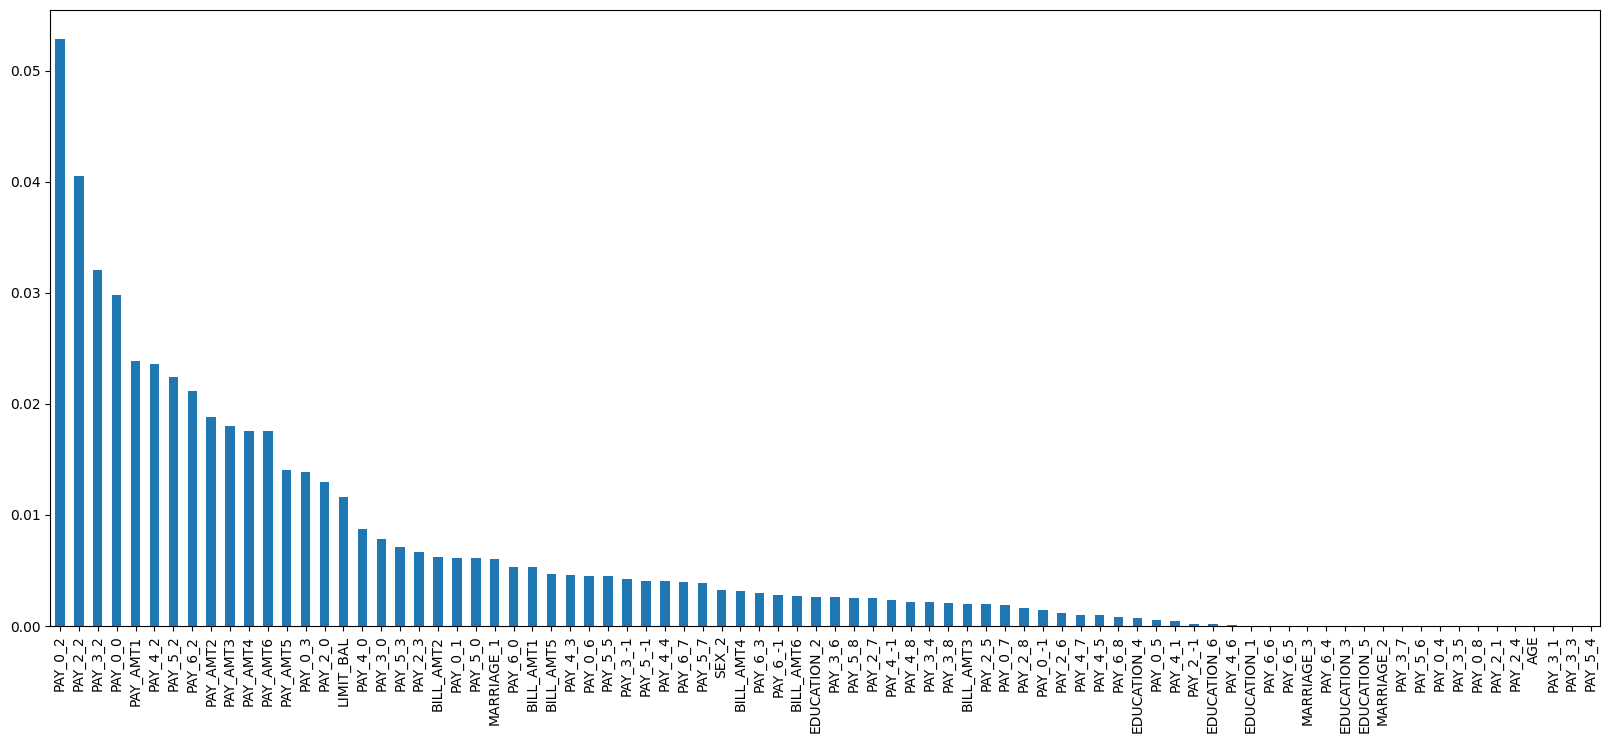

In [118]:
#Plotting the graph
#plot the ordered mutual_info values per feature

mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8));

In [119]:
# Selecting best 5 features
from sklearn.feature_selection import SelectKBest
#No we Will select the top 5 important features
sel_five_cols = SelectKBest(mutual_info_classif, k=5)
sel_five_cols.fit(X_train, y_train)
X_train.columns[sel_five_cols.get_support()]

Index(['PAY_0_0', 'PAY_0_2', 'PAY_2_2', 'PAY_3_2', 'PAY_4_2'], dtype='object')

In [120]:
df = plot()
df

,,Accuracy,Precision,Recall,F1
Training,0,0.999422,0.999396,0.997991,0.998693
Testing,0,0.818400,0.665552,0.359855,0.467136


## Shapley Additive Explanations (shap) Values

__SHAP (SHapley Additive exPlanations)__ is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see papers for details and citations).

In [ ]:
pip install shap

In [ ]:
import shap

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(clr, X_train)
shap_values = explainer(X_train)

# visualize the model's dependence on the first feature
shap.plots.scatter(shap_values[:, 0])

 24%|=====               | 10881/45000 [24:25<76:33]       